In [1]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import ee

from plot_functions import *

/DATA/magalhaes/ICESat-2_SVDA/JupyterNotebooks/subplots_boxplot_timeseries/plot_functions.py:12: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
#ee.Authenticate()

In [4]:
ee.Initialize()
print(ee.__version__)

0.1.337


In [5]:
directory = '/DATA/magalhaes/icesat2_atl03/atl03_hdf_window/'

file_pattern = ['ATL03_GrassHeight', 'ATL03_TOC']
start_date = '2018-10-14'
nmonths = 41 #all data

df_Grass, df_TOC = merge_df_nmonths(directory, start_date, nmonths, file_pattern)

In [7]:
df_TOC_index = df_TOC.set_index('Date')
df_Grass_index = df_Grass.set_index('Date')

df_TOC_mean = df_TOC_index.groupby(df_TOC_index.index.strftime('%Y-%m'))['TOC_Height'].mean().reset_index()
df_Grass_mean = df_Grass_index.groupby(df_Grass_index.index.strftime('%Y-%m'))['Grass_Height'].mean().reset_index()

df_Grass_mean = df_Grass_mean.set_index('Date')
df_TOC_mean = df_TOC_mean.set_index('Date')

In [8]:
# calculate mean values
df_TOC_mean = df_TOC.groupby('Date')['TOC_Height'].mean().reset_index()
df_Grass_mean = df_Grass.groupby('Date')['Grass_Height'].mean().reset_index()

df_Grass_mean = df_Grass_mean.set_index('Date')
df_TOC_mean = df_TOC_mean.set_index('Date')

df = pd.merge(df_TOC_mean, df_Grass_mean, on='Date', how='inner')

---

Get precipitation and land surface temperature time series data

In [9]:
from shapely.geometry import Polygon

# define region of interest
minx, maxx = 14, 17
miny, maxy = -20, -17

aoi = Polygon([[minx, maxy], [maxx, maxy], [maxx, miny], [minx, miny]])
ROI = gee_geometry_from_shapely(aoi)

# define period of time series analysis
start_date = '2018-10-01'
end_date = '2022-03-30'

/DATA/magalhaes/ICESat-2_SVDA/JupyterNotebooks/subplots_boxplot_timeseries/plot_functions.py:163: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  ty = geom.type


In [10]:
def createTS(image):
    date = image.get('system:time_start')
    value = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=ROI).get(var)
    std = image.reduceRegion(reducer=ee.Reducer.stdDev(), geometry=ROI).get(var)
    ft = ee.Feature(None, {'date': ee.Date(date).format('Y/M/d'), var: value, 'STD': std})
    return ft

def TS_to_pandas(TS):
    dump = TS.getInfo()
    fts = dump['features']
    out_vals = np.empty((len(fts)))
    out_dates = []
    out_std = np.empty((len(fts)))
    
    for i, f in enumerate(fts):
        props = f['properties']
        date = props['date']
        val = props[var]
        std = props['STD']
        out_vals[i] = val
        out_std[i] = std
        out_dates.append(pd.Timestamp(date))
    
    ser = pd.Series(out_vals, index=out_dates)
    return ser, out_std

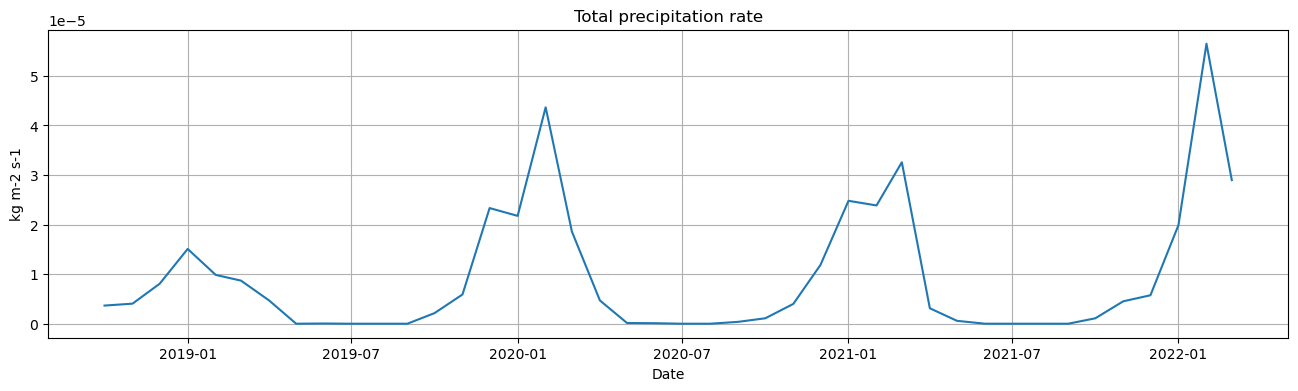

In [11]:
# Source of precipitation and soil moisture data
# https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001#description

Precip = ee.ImageCollection('NASA/FLDAS/NOAH01/C/GL/M/V001').filter(ee.Filter.date(start_date, end_date)).select('Rainf_f_tavg').filterBounds(ROI)     
var = 'Rainf_f_tavg'
TS = Precip.map(createTS)
Precip_ts, Precip_std = TS_to_pandas(TS)
precipitation = Precip_ts.groupby(Precip_ts.index.date).median()

precipitation.plot(figsize=(16,4))
plt.title('Total precipitation rate')
plt.xlabel('Date')
plt.ylabel('kg m-2 s-1')
plt.grid()

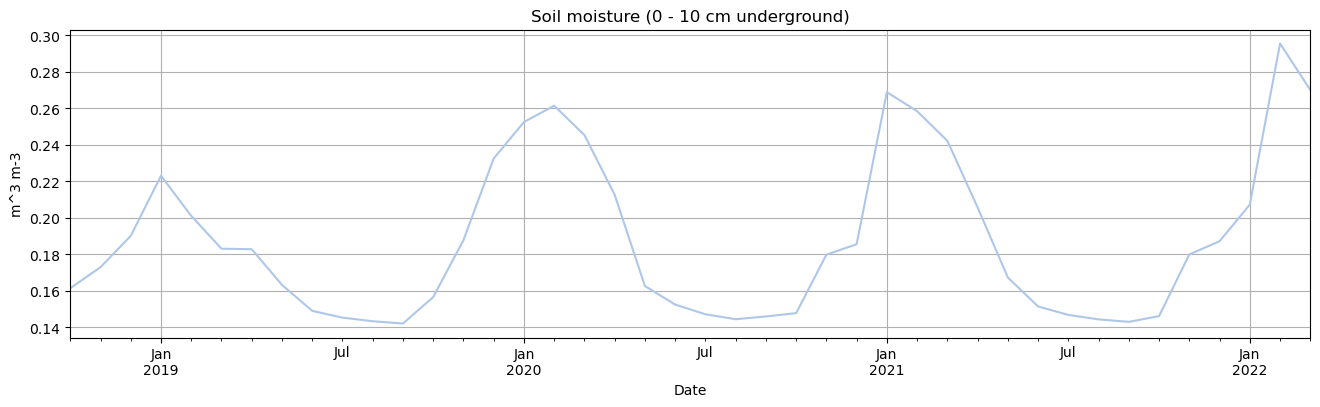

In [12]:
def createTS(image):
    date = image.get('system:time_start')
    value = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=ROI).get(var)
    std = image.reduceRegion(reducer=ee.Reducer.stdDev(), geometry=ROI).get(var)
    ft = ee.Feature(None, {'date': ee.Date(date).format('Y/M/d'), var: value, 'STD': std})
    return ft

def TS_to_pandas(TS):
    dump = TS.getInfo()
    fts = dump['features']
    out_vals = np.empty((len(fts)))
    out_dates = []
    out_std = np.empty((len(fts)))
    
    for i, f in enumerate(fts):
        props = f['properties']
        date = props['date']
        val = props[var]
        std = props['STD']
        out_vals[i] = val
        out_std[i] = std
        out_dates.append(pd.Timestamp(date))
    
    ser = pd.Series(out_vals, index=out_dates)
    return ser, out_std

Soil = ee.ImageCollection('NASA/FLDAS/NOAH01/C/GL/M/V001').filter(ee.Filter.date(start_date, end_date)).select('SoilMoi00_10cm_tavg').filterBounds(ROI)     
var = 'SoilMoi00_10cm_tavg'
TS = Soil.map(createTS)
soil_moisture, Soil_std = TS_to_pandas(TS)
soil_moisture.plot(figsize=(16,4), color='#aec7e8')

plt.title('Soil moisture (0 - 10 cm underground)')
plt.xlabel('Date')
plt.ylabel('m^3 m-3')
plt.grid()

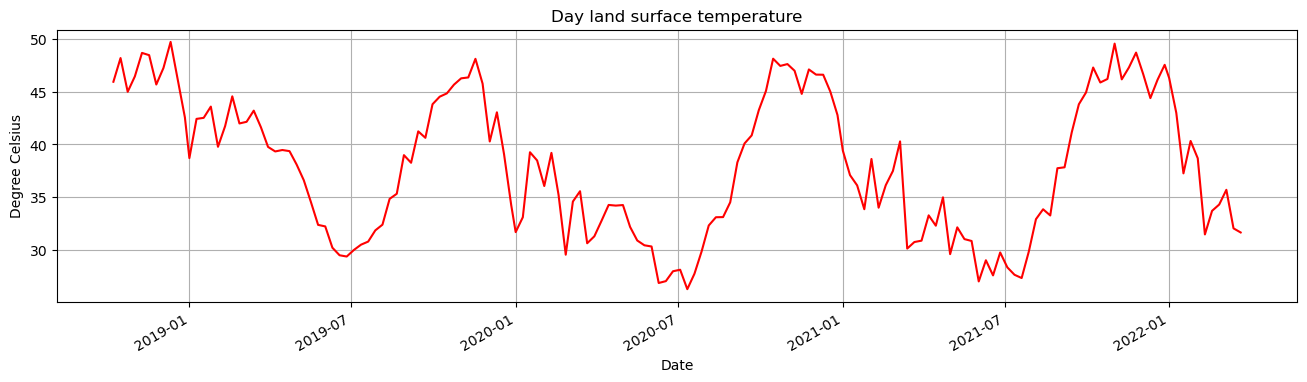

In [13]:
def rescale2(image):
    date = image.get('system:time_start')
    return image.multiply(scale_factor).subtract(273.15).set('system:time_start', date)

# Source of land surface temperature data
# https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD11A2

Temp = ee.ImageCollection('MODIS/006/MOD11A2').filter(ee.Filter.date(start_date, end_date)).select('LST_Day_1km').filterBounds(ROI)     
var = 'LST_Day_1km'
scale_factor = 0.02
Temp_rescale = Temp.map(rescale2)
TS = Temp_rescale.map(createTS)
temperature, Temp_std = TS_to_pandas(TS)

temperature.plot(figsize=(16,4), color='r')
plt.title('Day land surface temperature')
plt.xlabel('Date')
plt.ylabel('Degree Celsius')
plt.grid()

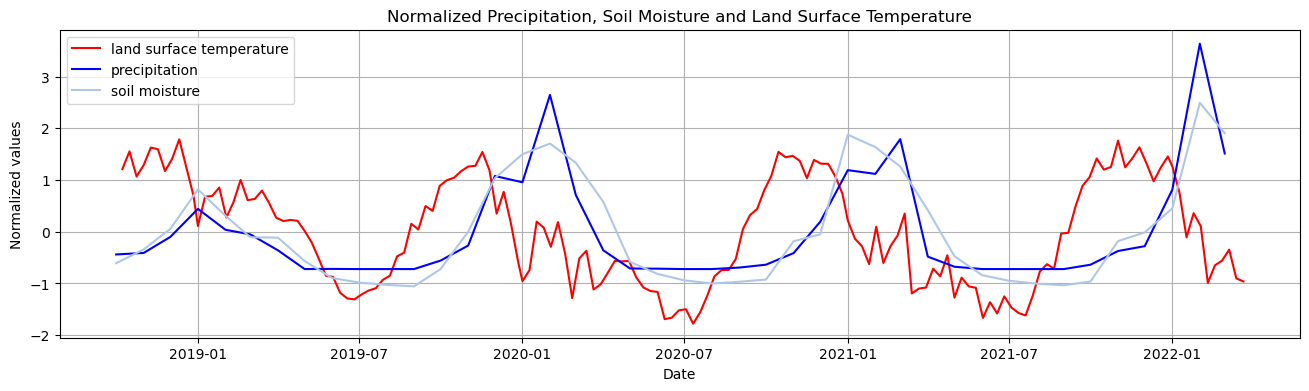

In [14]:
from sklearn.preprocessing import StandardScaler

# normalize precipitation and land surface temperature
precipitation_normalized = StandardScaler().fit_transform(precipitation.values.reshape(-1, 1))
soil_moisture_normalized = StandardScaler().fit_transform(soil_moisture.values.reshape(-1, 1))
temperature_normalized = StandardScaler().fit_transform(temperature.values.reshape(-1, 1))

plt.figure(figsize=(16,4))
plt.plot(temperature.index, temperature_normalized, color='r', label='land surface temperature')
plt.plot(precipitation.index, precipitation_normalized, color='b', label='precipitation')
plt.plot(soil_moisture.index, soil_moisture_normalized, color='#aec7e8', label='soil moisture')
plt.grid()

plt.xlabel('Date')
plt.ylabel('Normalized values')
plt.title('Normalized Precipitation, Soil Moisture and Land Surface Temperature')
plt.legend()
plt.show()

In [15]:
# calculate median values

df_TOC_median = df_TOC_index.groupby(df_TOC_index.index.strftime('%Y-%m'))['TOC_Height'].median().reset_index()
df_Grass_median = df_Grass_index.groupby(df_Grass_index.index.strftime('%Y-%m'))['Grass_Height'].median().reset_index()

df_Grass_median = df_Grass_median.set_index('Date')
df_TOC_median = df_TOC_median.set_index('Date')

In [16]:
df_TOC_index.shape

(18484695, 16)

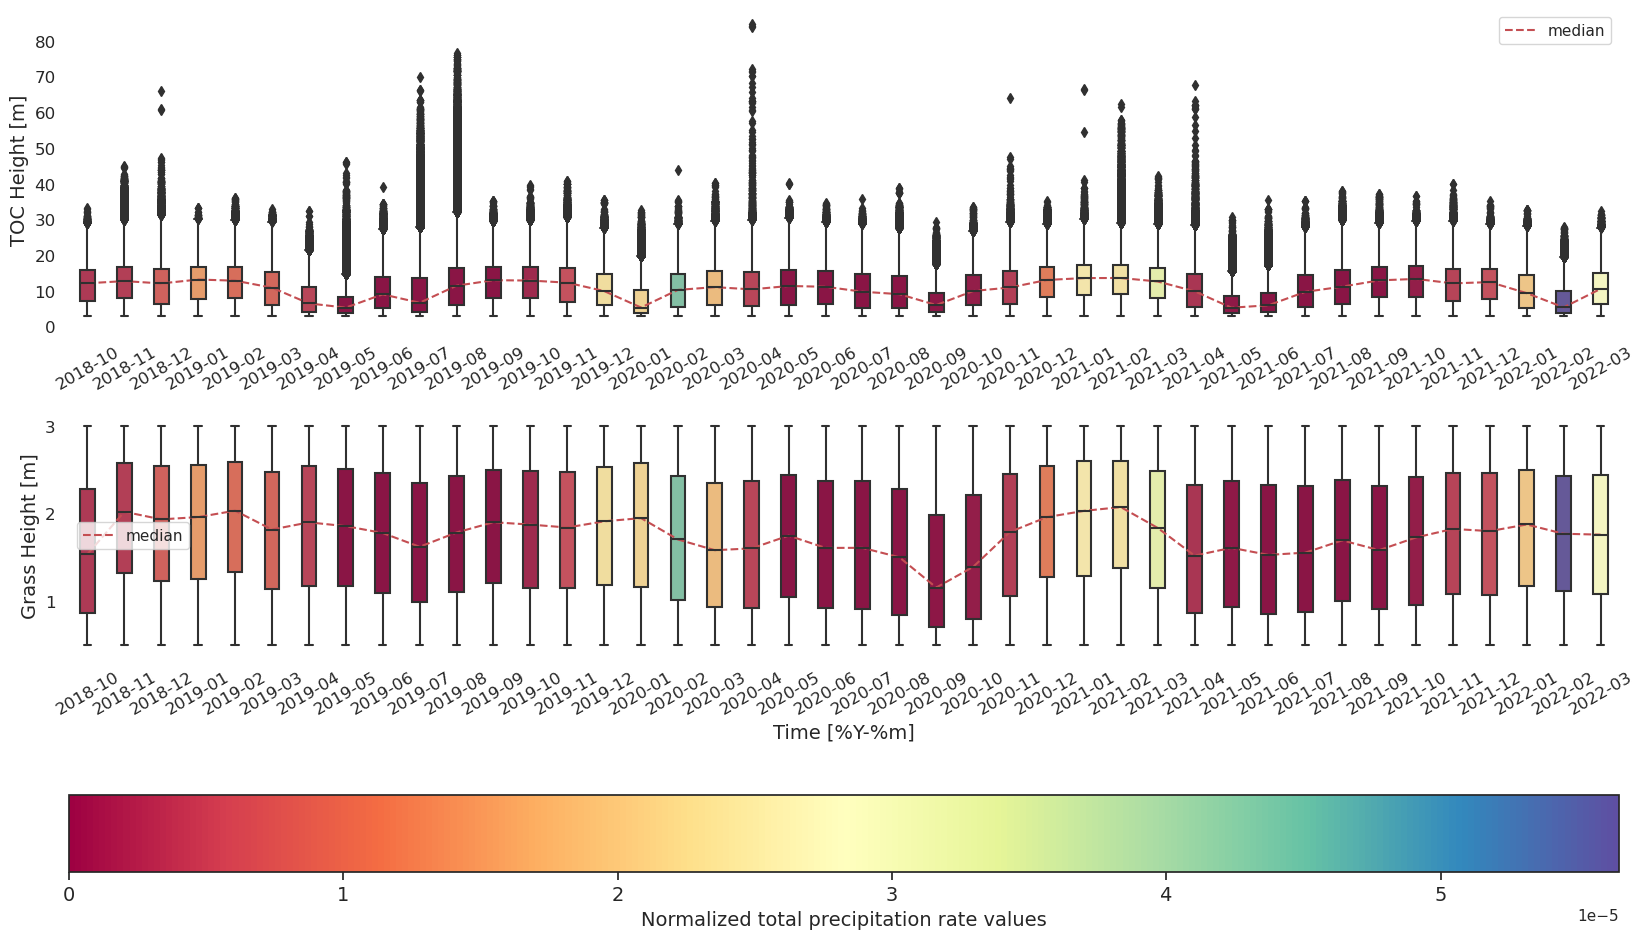

In [25]:
palette = 'Spectral'
sns.set(style='white')

fig, axs = plt.subplots(2,1, figsize=(20, 12), gridspec_kw={'height_ratios': [8, 6]})
# fig.suptitle(f'Top of Canopy and Grass Height boxplots grouped by each month, from October 2018 - March 2022', fontsize=12, y=0.94)
plt.subplots_adjust(hspace=0.3)
for ax in axs:
    for spine in ["top", "right", "bottom", "left"]:
        ax.spines[spine].set_visible(False)

norm = plt.Normalize(precipitation.min(), precipitation.max())
colors = plt.cm.Spectral(norm(precipitation))

sns.lineplot(data=df_TOC_median, x='Date', y='TOC_Height', ax=axs[0], linestyle='--',color='r', label='median')
sns.boxplot(x = df_TOC_index.index.strftime('%Y-%m'),
            y = df_TOC_index['TOC_Height'],
            palette = colors,
            ax=axs[0], width=0.4)

axs[0].set_xlabel('', fontsize=14)
axs[0].set_ylabel('TOC Height [m]', fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=30)

sns.lineplot(data=df_Grass_median, x='Date', y='Grass_Height', ax=axs[1], linestyle='--',color='r', label='median')
sns.boxplot(x = df_Grass_index.index.strftime('%Y-%m'),
            y = df_Grass_index['Grass_Height'],
            palette = colors,
            ax=axs[1], width=0.4)

axs[1].set_ylabel('Grass Height [m]', fontsize=14)
axs[1].set_xlabel('Time [%Y-%m]', fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=30)
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))

sm = plt.cm.ScalarMappable(cmap=palette, norm=plt.Normalize(vmin=precipitation.min(), vmax=precipitation.max()))
sm.set_array([])

cbar = plt.colorbar(sm, ax=axs.ravel().tolist(), orientation='horizontal', pad=0.15)
cbar.ax.set_xlabel('Normalized total precipitation rate values', fontsize=14)
cbar.ax.tick_params(axis='both', which='major', labelsize=14)
plt.show()

In [ ]:
df_TOC_index.index.strftime('%Y-%m')

In [ ]:
# Create a new monthly index with 2 month frequency
new_index = pd.date_range(start='2018-10-14', end='2022-12-30', freq='2MS')

In [ ]:
new_index

In [ ]:
palette = 'Spectral'
sns.set(style='dark')

fig, axs = plt.subplots(2,1, figsize=(20, 12), gridspec_kw={'height_ratios': [8, 6]})
fig.suptitle(f'Top of Canopy and Grass Height boxplots grouped by each month, from October 2018 - March 2022', fontsize=12, y=0.94)

norm = plt.Normalize(precipitation.min(), precipitation.max())
colors = plt.cm.Spectral(norm(precipitation))

# sns.lineplot(data=df_TOC_median, x='Date', y='TOC_Height', ax=axs[0], linestyle='--',color='r', label='median')
sns.boxplot(x = new_index, y = df_TOC_index['TOC_Height'], palette = colors, ax=axs[0], width=0.4)

axs[0].set_xlabel('', fontsize=10)
axs[0].set_ylabel('TOC Height [m]', fontsize=10)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=30)

# sns.lineplot(data=df_Grass_median, x='Date', y='Grass_Height', ax=axs[1], linestyle='--',color='r', label='median')
sns.boxplot(x = new_index, y = df_Grass_index['Grass_Height'], palette = colors, ax=axs[1], width=0.4)

axs[1].set_ylabel('Grass Height [m]', fontsize=10)
axs[1].set_xlabel('Time [%Y-%m]', fontsize=10)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=30)
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))

sm = plt.cm.ScalarMappable(cmap=palette, norm=plt.Normalize(vmin=precipitation.min(), vmax=precipitation.max()))
sm.set_array([])

cbar = plt.colorbar(sm, ax=axs.ravel().tolist(), orientation='horizontal', pad=0.1)
cbar.ax.set_xlabel('Normalized precipitation values', fontsize=10)
cbar.ax.tick_params(axis='both', which='major', labelsize=10)


In [ ]:
sns.set(style='dark')

fig, axs = plt.subplots(2,1, figsize=(20, 12), gridspec_kw={'height_ratios': [8, 6]})
fig.suptitle(f'Top of Canopy and Grass Height boxplots grouped by each month, from October 2018 - March 2022', fontsize=12, y=0.94)

sns.lineplot(data=df_TOC_median, x='Date', y='TOC_Height', ax=axs[0], linestyle='--',color='r', label='median')
sns.boxplot(x = df_TOC_index.index.strftime('%Y-%m'),
            y = df_TOC_index['TOC_Height'],
            ax=axs[0], width=0.4)

axs[0].set_xlabel('', fontsize=10)
axs[0].set_ylabel('TOC Height [m]', fontsize=10)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=30)

sns.lineplot(data=df_Grass_median, x='Date', y='Grass_Height', ax=axs[1], linestyle='--',color='r', label='median')
sns.boxplot(x = df_Grass_index.index.strftime('%Y-%m'),
            y = df_Grass_index['Grass_Height'],
            ax=axs[1], width=0.4)

axs[1].set_ylabel('Grass Height [m]', fontsize=10)
axs[1].set_xlabel('Time [%Y-%m]', fontsize=10)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=30)
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# calculate median values

df_TOC_median = df_TOC_index.groupby(df_TOC_index.index.strftime('%Y-%m-%d'))['TOC_Height'].median().reset_index()
df_Grass_median = df_Grass_index.groupby(df_Grass_index.index.strftime('%Y-%m-%d'))['Grass_Height'].median().reset_index()

df_Grass_median = df_Grass_median.set_index('Date')
df_TOC_median = df_TOC_median.set_index('Date')

In [ ]:
# Boxplot time series of all raw values without grouping

sns.set(style='dark')

fig, axs = plt.subplots(2,1, figsize=(40, 32), gridspec_kw={'height_ratios': [8, 6]})
fig.suptitle(f'Top of Canopy and Grass Height boxplots grouped by each date, from October 2018 - March 2022', fontsize=12, y=0.94)

sns.lineplot(data=df_TOC_median, x='Date', y='TOC_Height', ax=axs[0], linestyle='--',color='r', label='median')
sns.boxplot(x = df_TOC_index.index.strftime('%Y-%m-%d'),
            y = df_TOC_index['TOC_Height'],
            ax=axs[0], width=0.4)

axs[0].set_xlabel('', fontsize=10)
axs[0].set_ylabel('TOC Height [m]', fontsize=10)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=30)

sns.lineplot(data=df_Grass_median, x='Date', y='Grass_Height', ax=axs[1], linestyle='--',color='r', label='median')
sns.boxplot(x = df_Grass_index.index.strftime('%Y-%m-%d'),
            y = df_Grass_index['Grass_Height'],
            ax=axs[1], width=0.4)

axs[1].set_ylabel('Grass Height [m]', fontsize=10)
axs[1].set_xlabel('Time [%Y-%m-%d]', fontsize=10)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=30)
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
# calculate mean values
df_TOC_mean = df_TOC.groupby('Date')['TOC_Height'].mean().reset_index()
df_Grass_mean = df_Grass.groupby('Date')['Grass_Height'].mean().reset_index()

df_Grass_mean = df_Grass_mean.set_index('Date')
df_TOC_mean = df_TOC_mean.set_index('Date')

In [ ]:
sns.set(style='dark')

fig, axs = plt.subplots(2,1, figsize=(15,7), gridspec_kw={'height_ratios': [8, 6]})
fig.suptitle(f'Top of Canopy and Grass Height: from October 2018 - March 2022, grouped by Month', fontsize=12, y=0.94)

sns.boxplot(x = df_TOC_index.index.month,
            y = df_TOC_index['TOC_Height'],
            ax=axs[0], width=0.2)

axs[0].set_xlabel('', fontsize=10)
axs[0].set_ylabel('TOC Height [m]', fontsize=10)
axs[0].tick_params(axis='both', which='major', labelsize=10)
# axs[0].set_ylim(3, 16)

sns.boxplot(x = df_Grass_index.index.month,
            y = df_Grass_index['Grass_Height'],
            ax=axs[1], width=0.2)

axs[1].set_ylabel('Grass Height [m]', fontsize=10)
axs[1].set_xlabel('Month', fontsize=10)
axs[1].tick_params(axis='both', which='major', labelsize=10)
# axs[1].set_ylim(0, 3)
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))


---

In [ ]:
def df_cumulative_counts(dataframes):
    """
    Calculates the cumulative counts of unique dates in the given column for each month for a list of dataframes.

    Parameters:
    dataframes (list): A list of pandas DataFrames.
    
    Returns:
    list of dataframes
    """
    # Create a date range from 2018-10-01 to 2022-03-30
    date_range = pd.date_range(start='2018-10-01', end='2022-03-30', freq='D')

    # Create a DataFrame with the date range as the index
    df = pd.DataFrame(index=date_range)

    # Create an empty list to hold the counts for each DataFrame
    counts_list = []

    # Loop through each DataFrame and count the unique dates for each month
    for df in dataframes:
        counts = df.groupby(pd.Grouper(freq='M')).size().reset_index()
        counts = counts.rename(columns={0: 'counts_unique_dates'})
        counts['cumulative_sum'] = counts['counts_unique_dates'].cumsum()
        counts.set_index('Date', inplace=True)
        counts_list.append(counts)
    
    return counts_list

In [ ]:
df_Grass_count, df_TOC_count = df_cumulative_counts([df_Grass_mean, df_TOC_mean])

In [ ]:
# Plot the counts
sns.set(style='darkgrid')
plt.figure(figsize=(16, 8))

#plt.plot(df_Grass_count.index.strftime('%Y-%m'), counts['cumulative_sum'], label='Grass')
plt.plot(df_TOC_count.index.strftime('%Y-%m'), counts['cumulative_sum'], label='TOC')
plt.xlabel('Date')
plt.xticks(counts.index.strftime('%Y-%m'), rotation=90)
plt.ylabel('Cumulative Number of Unique Dates')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a date range from 2018-10-01 to 2022-03-30
date_range = pd.date_range(start='2018-10-01', end='2022-03-30', freq='D')

# Create a DataFrame with the date range as the index
df = pd.DataFrame(index=date_range)

# counts the number of dates for each month
counts = df_Grass_mean.groupby(pd.Grouper(freq='M')).size().reset_index()
counts = counts.rename(columns={0: 'counts_unique_dates'})
counts['cumulative_sum'] = counts['counts_unique_dates'].cumsum()
counts.set_index('Date', inplace=True)

# Plot the counts
sns.set(style='darkgrid')
plt.figure(figsize=(16, 8))

plt.plot(counts.index.strftime('%Y-%m'), counts['cumulative_sum'])
plt.xlabel('Date')
plt.xticks(counts.index.strftime('%Y-%m'), rotation=90)
plt.ylabel('Cumulative Number of Unique Dates')
plt.show()

---